In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

使用 `d2l` 自带的方法读取图片并显示

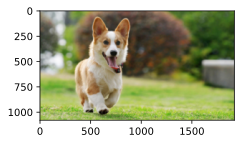

In [2]:
d2l.set_figsize()
img = d2l.Image.open('./data/picture/dog/dog-1.png')
d2l.plt.imshow(img)

`apply` 函数是使同一张图片作用 $\text{num rows} \times \text{num cols}$ 次增广

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5): # aug 是增广函数，num_rows 和 num_cols 是增广出来的图像行列数，两者相乘其实就是增广数量，scale 是将原有图片放缩倍数
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 随机翻转

`RandomHorizontalFlip` 是随机的在水平方向翻转|

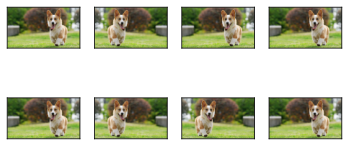

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

`RandomVerticalFlip` 是随机的在垂直方向翻转，很明显，这张图不适用

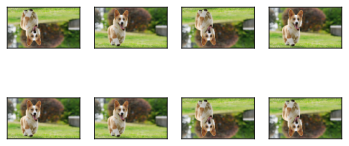

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

### 随机裁剪

`RandomResizedCrop` 实现随机的裁剪图片，`scale` 参数代表裁剪的随机范围，`ratio` 为高宽比

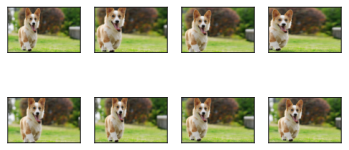

In [6]:
apply(img, torchvision.transforms.RandomResizedCrop(size=(125, 200), scale=(0.5, 1), ratio=(0.5, 2)))

### 随机改变亮度

`ColorJitter` 用于随机改变亮度、饱和度、对比度、色调，数字代表在 (-num, +num) 范围内改变

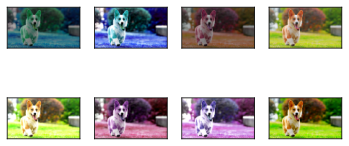

In [7]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=1, hue=0.5))

### 结合多种图像增广

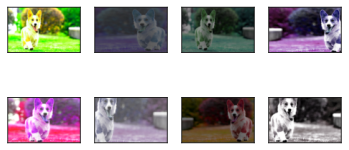

In [8]:
horizontalFlip_aug = torchvision.transforms.RandomHorizontalFlip()
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=1, hue=0.5)
shape_aug = torchvision.transforms.RandomResizedCrop(size=(125, 200), scale=(0.5, 1), ratio=(0.5, 2))
augs = torchvision.transforms.Compose([horizontalFlip_aug, color_aug, shape_aug])
apply(img, augs)

### 利用图像增广进行训练

读取 CIFAR10 数据集，图片大小为 32 x 32，一共 10 个类，构造为 `img[index][0:img, 1:label]`

In [9]:
all_images = torchvision.datasets.CIFAR10(train=True, root="./data", download=False)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

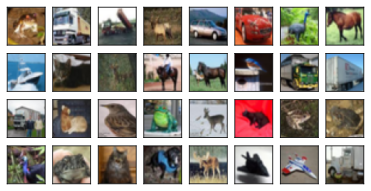

In [10]:
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

`torchvision.transforms.ToTensor()` 将图像变成形状为 `channels x height x width` 的 32 位浮点数，取值范围：$[0, 1]$

变为浮点数的操作也属于数据增广

In [12]:
train_augs = torchvision.transforms.Compose([horizontalFlip_aug, torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

使用 `DataLoader` 加载 `CIFAR10` 数据

In [14]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='./data', train=is_train, transform=augs, download=False)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers())

一个 batch 训练

In [20]:
def train_batch_ch13(net: nn.Module, X, y, loss, trainer, devices):
    X = [x.to(devices[0]) for x in X]
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X) # 预测值
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [17]:
def train_ch13(net: nn.Module, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0,1], legend=['train loss', 'train acc', 'test acc'])
    net = net.to(device=devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')
    

In [18]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weight(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weight)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='None')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10)

D:\Software\work\conda\miniconda\envs\pytorch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
# train_with_data_aug(train_augs, test_augs, net)

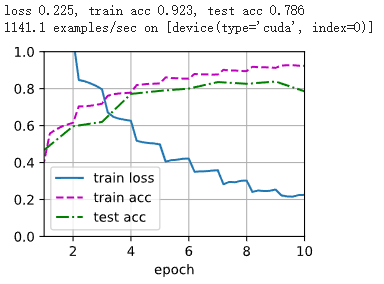